# **Analyse de sentiments sur les critiques spectateurs sur Allociné**
**Projet Python pour la Data science - 2A ENSAE**

Zakaria BOULLIAIRE, Massyle DENDENE, Brian RAMESH

# Introduction

L'idée de ce projet est de prédire la performance au box office des films, à partir d'une analyse de sentiment faite sur les critiques données pas les spectateurs (et non la presse), sur le site Allociné. 
En effet, les critiques jouent souvent sur notre manière d'approcher le film et influencent en général notre avis. Ainsi, le but de ce projet est d'extraire l'information sur la trajectoire du succès d'un film qui est captée par ces critiques.

Nous allons donc consituer une base de données de film, en scrappant le site Allociné et en utilisant l'API de The Movie Database (TMDB) pour compléter les données manquantes. Le projet sera guidé selon les étapes de base qui sructureront notre étude, c'est-à-dire : récupération et nettoyage des données, visualisation, modélisation et conclusion/application.

### Imports nécessaires

*Pensez à installer tous les packages nécessaires, en exécutant la commande suivante dans le terminal : "pip install -r requirements.txt"*

In [2]:
# BeutifulSoup pour le scrapping
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import requests
from concurrent.futures import ThreadPoolExecutor

In [3]:
# Classique python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import seaborn as sns
from warnings import warn
from time import sleep
from datetime import datetime
from dateutil import parser 

In [4]:
#Data Visualisation et Stat Descriptives 
from tabulate import tabulate
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random

In [5]:
# NLP
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

In [6]:
# ML

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection, preprocessing, naive_bayes, metrics
from sklearn import decomposition, ensemble

# 1) Collecte et nettoyage des données 

Notre collecte des données s'est structurée en plusieurs temps. Nous avons d'abord récupéré les films qui nous intéressaient sur allociné. Ensuite nous avons complété les informations d'allociné avec la base de données de TMDB. Puis, nous avons uni les deux database pour regrouper les informations. La dernière étape consistait à récupérer les critiques spectateurs de tous les films qui étaient présents dans la base unifiée finale.

## a) Allociné

### i) Scrapping des données

Tout d'abord, nous avons restreint notre base de données aux films américains des années 2010 à 2021. Cela constitue une base de données de 11 822 films (avant nettoyage).

Les données qui peuvent nous être utiles sont les suivantes : Titre original du film, identifiant du film sur Allociné (qui nous sera utile pour récupérer les critiques plus tard), la note des spectateurs et celle de la presse, le nombre de critiques presse, le nombre de critiques spectateurs et le nombre de votes pour la note (dans une seule et même variable, qu'on spérera lors du nettoyage), la date de sortie du film, le budget et le Box Office US. 
Nous avions également commencer à scrapper le N°Visa du film, qui est unique pour chaque film, en vue d'utiliser cette donnée pour la collecte sur TMDB, mais il y avait énormément de film pour lesquels cette donnée manquait. Nous avons décidé de ne pas l'utiliser.

L'idée de la fonction ci dessous est de scrapper les données dont on a besoin à partir de l'url et du nombre de page.

In [40]:
# Role : Scraping des pages de film sur le site allocine.fr
# Entrée : url et nombre de de page
# Sortie : un dataframe contenant toutes les données scrapées
 
def scraping_film_allocine(base_url, nb_page):

    # Liste ou on stock nos données
    data = []
    
    # Variable de comptage pour voir l'évolution du scrapping, et détecter les eventuelles erreurs
    i=0

    # Boucle sur les pages
    for page in range(1, nb_page+1): 
        url_page_ac = f"{base_url}{page}"

        response_page_ac = requests.get(url_page_ac)

        if response_page_ac.status_code == 200:
            bs_page_ac = bs(response_page_ac.text, "html.parser")
            films_page_ac = bs_page_ac.findAll("li", attrs={'class': "mdl"})

            for film_allocine in films_page_ac:
                i+=1
                try:
                    
                    # Id du film sur allo cine
                    meta_title_link = film_allocine.find('a', class_='meta-title-link')

                    if meta_title_link:
                        href1 = meta_title_link.get('href')
                        film_id = href1.split('=')[-1].split('.')[0]
                    else:
                        film_id = None


                    # Scrapping de la page fiche info du film qu'on obtient grace à l'id trouvé ci dessus
                    url_fiche_film = f'https://www.allocine.fr/film/fichefilm_gen_cfilm={film_id}.html'
                    response_fiche_film = requests.get(url_fiche_film)
                    bs_fiche_film = bs(response_fiche_film.text, "html.parser")

                    # Titre
                    titre_allocine = meta_title_link.text

                    span_titre_original = bs_fiche_film.find('span', class_='light', string='Titre original ')
                    titre_original = span_titre_original.find_next_sibling(string=True).strip() if span_titre_original else titre_allocine


                    # Notes spectateurs/presse, nombre critiques presse/spectateurs
                    bloc_notes = bs_fiche_film.findAll('span', class_='stareval-note')
                    list_notes = [notes.get_text(strip=True) for notes in bloc_notes]

                    if len(list_notes)==0:
                        note_presse = None
                        note_spectateur = None
                        
                    else:
                        index_delimiteur = list_notes.index('--')
                        new_liste_notes = list_notes[:index_delimiteur]

                        if len(new_liste_notes)==2:
                            note_presse = new_liste_notes[0]
                            note_spectateur = new_liste_notes[1]
                        
                        elif len(new_liste_notes) > 0 and len(new_liste_notes) <= 1:
                            note_spectateur = new_liste_notes[0]
                            note_presse = None

                    bloc_critiques = bs_fiche_film.find_all('span', class_='stareval-review')

                    if len(bloc_critiques)==2:
                        critiques_element_presse = bloc_critiques[0].text
                        critiques_element_spec = bloc_critiques[1].text
                    elif len(bloc_critiques) > 0 and len(bloc_critiques) <= 1:
                        critiques_element_spec = bloc_critiques[0].text
                        critiques_element_presse = None
                    else:
                        critiques_element_presse = None
                        critiques_element_spec = None


                    #Date, durée, budget, réalisateur
                    date_film_element = film_allocine.find('span', class_='date')
                    date_film = date_film_element.text if date_film_element else None

                    duree_film_element = bs_fiche_film.find('span', class_='spacer')
                    duree_film = duree_film_element.next_sibling.strip() if duree_film_element else None

                    budget_element = bs_fiche_film.find('span', class_='what light', string='Budget')
                    budget_film = budget_element.find_next('span').string if budget_element else None

                    director_element = bs_fiche_film.find('div', class_='meta-body-direction')
                    director_name = director_element.text.strip() if director_element else None


                    data.append([titre_original, note_presse, note_spectateur, critiques_element_presse, critiques_element_spec, film_id, director_name, budget_film,
                                date_film, duree_film])
                    
                    df_data = pd.DataFrame(data, columns=["Titre original", "Note presse", "Note spectateur", "Critique presse", "Critique spectateurs", 'id allocine',
                                          'Réalisateur', 'Budget', 'date', 'duree'])


                    print(i)
                except Exception as e:
                    print(f"Une erreur s'est produite pour le film {i} : {e}")

    return df_data

In [41]:
%%time

# Urls qu'on veut scrapper
base_url_2010_2020, nb_page_2010_2020 = 'https://www.allocine.fr/films/pays-5002/decennie-2010/?page=', 646
base_url_2020, nb_page_2020 = 'https://www.allocine.fr/films/pays-5002/decennie-2020/annee-2020/?page', 66
base_url_2021, nb_page_2021 = 'https://www.allocine.fr/films/pays-5002/decennie-2020/annee-2021/?page', 77

# Application de la fonction scrapping_film_allocine
df_data_2010_2020 = scraping_film_allocine(base_url_2010_2020, nb_page_2010_2020)
df_data_2020 = scraping_film_allocine(base_url_2020, nb_page_2020)
df_data_2021 = scraping_film_allocine(base_url_2021, nb_page_2021)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [43]:
# Créer un DataFrame avec les données collectées
dfs=[df_data_2010_2020, df_data_2020, df_data_2021]

df_film_ac = pd.concat(dfs, ignore_index=True)

A ce stade, nous avons donc récupéré les informations sur les films que nous avons stockées dans le fichier *df_film_ac.csv*. Nous avons pris l'habitude de stocker au fur et à mesure nos données dans des fichiers csv car les processus de récupération de données prennent parfois beaucoup de temps donc cela nous assurait l'accès aux données sans avoir besoin de les récupérer à chaque utilisation

In [44]:
df_film_ac.to_csv('df_film_ac.csv', index=False) ### DF important

### ii)  Nettoyage de la base Allociné

In [54]:
df_film_ac= pd.read_csv("df_film_ac.csv")
df_film_ac.head()

,Titre original,Note presse,Note spectateur,Critique presse,Critique spectateurs,id allocine,Réalisateur,Budget,date,duree
0,The Commuter,"2,4","3,2",17 critiques,7079 notes dont 342 critiques,177592,De\nJaume Collet-Serra,-,24 janvier 2018,1h 44min
1,Aquaman,"2,7","3,4",18 critiques,18520 notes dont 1215 critiques,208692,De\nJames Wan,$160.000.000,19 décembre 2018,2h 24min
2,Dark Waters,"4,0","4,1",37 critiques,7533 notes dont 345 critiques,269509,De\nTodd Haynes,-,26 février 2020,2h 08min
3,The Hunger Games,"3,4","3,8",21 critiques,60464 notes dont 3244 critiques,145083,De\nGary Ross,78 000 000 $,21 mars 2012,2h 22min
4,The Promise,"2,2","3,9",14 critiques,820 notes dont 91 critiques,238649,De\nTerry George,"$90,000,000 dlls",29 novembre 2017,2h 13min


Comme nous pouvons le voir, la base a besoin d'être nettoyé. Nous allons extraire le nombre de critiques de la presse, le nombre de notes spectateurs et le nombre de critiques des spectateurs. Nous allons convertir également le format de la date, et la durée du film en minute pour une manipulation plus facile.

Puis, nous allons supprimer tous les films qui n'ont pas de note spectateurs et/ou qui ont moins de 5 critiques (ces films ne nous serviront pas pour notre étude). Nous commençons par voir les types des différentes variables pour savoir ce que nous devons modifier.

In [53]:
print(df_film_ac.dtypes)

Titre original           object
Note presse             float64
Note spectateur         float64
Critique presse          object
Critique spectateurs     object
id allocine               int64
Réalisateur              object
Budget                   object
date                     object
duree                    object
dtype: object


On change d'abord la structure des observations et on les convertit en type adéquat.

In [55]:
#On convertit toutes les variables de notes qui sont de la forme 3,5 en float 
df_film_ac['Note presse'] = df_film_ac['Note presse'].str.replace(',', '.').astype(float)
df_film_ac['Note spectateur'] = df_film_ac['Note spectateur'].replace("--", np.nan)
df_film_ac['Note spectateur'] = df_film_ac['Note spectateur'].str.replace(',', '.').astype(float)

La cellule suivante regroupe toutes les fonctions nécessaires pour nettoyer les données de façon à pouvoir les manipuler par la suite.

In [57]:
#cette fonction converti les mois français en anglais , en prenant en entrée les mois français
#et en donnant en sortie le mois en anglais

def french_to_english_month(month_french):
    months_mapping = {
        'janvier': 'January',
        'février': 'February',
        'mars': 'March',
        'avril': 'April',
        'mai': 'May',
        'juin': 'June',
        'juillet': 'July',
        'août': 'August',
        'septembre': 'September',
        'octobre': 'October',
        'novembre': 'November',
        'décembre': 'December'
    }
    return months_mapping.get(month_french.lower(), month_french)
    

#cette fonction convertit les heures en minutes en prenant en entrée la chaîne de caractères de l'heure
#et renvoie en sortie la durée en minute

def convert_duration(duration_str):
    if isinstance(duration_str, str):
        # Supprime les espaces et divise la chaîne en parties
        parts = duration_str.replace(' ', '').split('h')

        # Vérifie la présence des heures et des minutes
        if len(parts) == 2:
            hours = int(parts[0])
            minutes = 0 if 'min' not in parts[1] else int(parts[1].replace('min', ''))
            
            # Calcule la durée en minutes
            total_minutes = hours * 60 + minutes
            
            return int(total_minutes)
            
    # Gère le cas où la valeur est déjà un nombre ou ne peut pas être convertie
    return float('nan')
    

#cette fonction extrait le nombre de critiques de la presse en prenant en entrée une chaîne de caractères de la forme "21 critiques"
#et renvoie en sortie nombre sous forme d'entier (soit 21 ici)

def extract_critiques_count(critiques_str):
    if isinstance(critiques_str, str):
        # Utiliser isdigit() pour extraire uniquement les chiffres
        return np.nan if not critiques_str.split()[0].isdigit() else int(critiques_str.split()[0])
    else:
        return np.nan


#cette fonction extrait le nombre de notes et de critiques des spectateurs en prenant en entrée une chaîne de caractères de la forme 80471 notes dont 4605 critiques"
#et renvoie en sortie nombre sous forme d'entiers (soit 80471 et 4605 ici)

def extract_notes_and_critiques_count(critiques_str):
    if isinstance(critiques_str, str):
        # Trouver les nombres dans la chaîne
        numbers = [int(word) for word in critiques_str.split() if word.isdigit()]

        # Extraire le nombre de notes et de critiques en fonction de la longueur de la liste "numbers"
        if len(numbers) == 1:
            return numbers[0], np.nan
        elif len(numbers) == 2:
            return numbers[0], numbers[1]

    # Gérer le cas où la valeur est déjà un nombre ou ne peut pas être convertie
    return np.nan, np.nan

On applique ensuite cette série de fonctions au datframe afin d'obtenir à la fin un dataframe propre.

In [59]:
# Remplacer les chaînes "nan" par des valeurs NaN
df_film_ac['date'] = df_film_ac['date'].replace('nan', np.nan)

# Appliquer la fonction pour convertir le mois en anglais
df_film_ac['date'] = df_film_ac['date'].apply(lambda x: ' '.join([french_to_english_month(word) for word in str(x).split()]) if pd.notna(x) else np.nan)

# Utiliser dateutil.parser.parse pour convertir les dates en objets datetime
df_film_ac['date'] = df_film_ac['date'].apply(lambda x: parser.parse(x, dayfirst=True) if isinstance(x, str) else x)

# Appliquer la fonction de conversion pour la durée
df_film_ac['duree_minutes'] = df_film_ac['duree'].apply(convert_duration)

# Appliquer la fonction extract_notes_and_critiques_count
df_film_ac[['Nombre_de_notes_spectateurs', 'Nombre_de_critiques_spectateurs']] = df_film_ac['Critique spectateurs'].apply(extract_notes_and_critiques_count).apply(pd.Series)

# Appliquer la fonction extract_critiques_count
df_film_ac['Nombre_de_critiques_presse'] = df_film_ac['Critique presse'].apply(extract_critiques_count)

In [62]:
# Retrait des colonnes inutiles 
colonnes_a_retirer = ["Critique presse","Critique spectateurs","duree","Budget"]
df_film_ac = df_film_ac.drop(colonnes_a_retirer,axis=1)

In [63]:
# Retrait de tous les films sans critique spectateurs
# On garde que les films avec au moins plus de 5 commentaires

df_film_ac_clean = df_film_ac.dropna(subset=['Nombre_de_critiques_spectateurs'])
df_film_ac_clean = df_film_ac_clean[df_film_ac_clean['Nombre_de_critiques_spectateurs'] >= 5]

In [64]:
# Extraire le jour, le mois et l'année dans des colonnes distinctes
df_film_ac_clean['mois_sortie'] = df_film_ac_clean['date'].dt.month
df_film_ac_clean['annee_sortie'] = df_film_ac_clean['date'].dt.year

In [70]:
#Nettoyer nom du réalisateur
df_film_ac_clean['Réalisateur'] = df_film_ac_clean['Réalisateur'].str.replace('De\n', '')

In [71]:
#ne pas mettre dans la meme cellule qu'avant
df_film_ac_clean['Réalisateur'] = df_film_ac_clean['Réalisateur'].str.replace('\n', '')

In [72]:
#df_film_ac_clean.to_csv('df_film_ac_clean.csv', index=False) #dataframe propre contenant les données allociné
df_film_ac_clean.head()

,Titre original,Note presse,Note spectateur,id allocine,Réalisateur,date,duree_minutes,Nombre_de_notes_spectateurs,Nombre_de_critiques_spectateurs,Nombre_de_critiques_presse,mois_sortie,annee_sortie
0,The Commuter,2.4,3.2,177592,Jaume Collet-Serra,2018-01-24,104.0,7079.0,342.0,17.0,1.0,2018.0
1,Aquaman,2.7,3.4,208692,James Wan,2018-12-19,144.0,18520.0,1215.0,18.0,12.0,2018.0
2,Dark Waters,4.0,4.1,269509,Todd Haynes,2020-02-26,128.0,7533.0,345.0,37.0,2.0,2020.0
3,The Hunger Games,3.4,3.8,145083,Gary Ross,2012-03-21,142.0,60464.0,3244.0,21.0,3.0,2012.0
4,The Promise,2.2,3.9,238649,Terry George,2017-11-29,133.0,820.0,91.0,14.0,11.0,2017.0


In [73]:
print("On passe donc de",len(df_film_ac),"films à", len(df_film_ac_clean), "films")

On passe donc de 11833 films à 5692 films


## b) TMDB (The Movie Database)

Nous avons ensuite décidé de récupérer des données complémentaires sur les films de la database *df_film_ac_clean* afin d'avoir des informations supplémentaires sur les films et voir également la répartion de nos films en termes de genres, pays de production, collections, etc. Ces informations n'étant pas directement disponible sur allociné, cette récupération nous permettait donc voir la diversité de nos données afin de ne pas avoir des résultats biaisés au final

### i) Récupération des données sur TMDB

La récupération des données sur TMDB nécessite l'utilisation de l'API du site. Less données sont libre d'accès à condition de créer des identifiants et une clé d'accès aux données qui est la suivante:

In [ ]:
key_api='d1d1413d8379729633d60e9f5cc4a730'

Il s'avère que le fonctionnement de l'API de TMDB est particulier car l'accès aux données se fait en deux étapes : pour chaque film nous devons accéder à son identifiant TMDB et ensuite, cet identifiant permet d'accéder à toutes les informations du film.

L'idée est donc la suivante : 

-Nous avons récupéré tous les titres des films qui sont dans la table *df_film_ac_clean* sous forme de liste
    
 -Cette liste nous permet d'accéder aux identifiants de ces films
    
 -A partir de ces identifiants, nous avons créer une fonction qui permet d'accéder aux informations.
    
 Les fonctions ci-dessous retracent donc les étapes de ce raisonnement.

In [ ]:

# Fonction pour récupérer l'id du film (à partir du titre du film issu de la base scrappé sur allociné)
def id_recup(titre):
    url = f"https://api.themoviedb.org/3/search/movie?api_key={key_api}&query={titre}" 
    req = requests.get(url)
    carte = req.json()

    #création d'une liste vide qui va accumuler tous les identifiants au fur et à mesure
    ind=[]
    for film in range(len(carte['results'])):
        ind.append(carte['results'][film]['id'])
    return(ind)


# Fonction pour récuperer les infos du film à partir de l'id (prend en entrée l'id du film sur tmdb et renvoie un dataframe)
def recup_info(id):
    id_film= id
    url_id = f"https://api.themoviedb.org/3/movie/{id_film}?api_key={key_api}&language=en-US"
    req_id = requests.get(url_id)
    wb_id = req_id.json()
    
    
    #données collection 
    if 'belongs_to_collection' in wb_id and wb_id['belongs_to_collection'] is not None:
        wb_id['belongs_to_collection'] = wb_id['belongs_to_collection']['name']

    # données genres
    if 'genres' in wb_id:
        wb_id['genres'] = ', '.join([x['name'] for x in wb_new['genres']])
    else:
        wb_id['genres'] = None

    # données production_companies
    if 'production_companies' in wb_new:
        wb_new['production_companies'] = ', '.join([x['name'] for x in wb_new['production_companies']])
    else:
        wb_new['production_companies'] = None

    # données production_countries
    if 'production_countries' in wb_id:
        wb_id['production_countries'] = ', '.join([x['name'] for x in wb_new['production_countries']])
    else:
        wb_id['production_countries'] = None

    #données spoken_languages
    if 'spoken_languages' in wb_id:
        wb_id['spoken_languages'] = ', '.join([x['name'] for x in wb_new['spoken_languages']])
    else:
        wb_id['spoken_languages'] = None

    
    df_tm =pd.DataFrame(wb_id, index=[0])
    
    return (df_tm)


#cette fonction récupère les informations de tous les films et les mets dans un meme dataframe

def create_movie_list(movie_list):
    all_movies_df = pd.DataFrame()

    for movie_name in movie_list:
        movie_id_list = id_recup(movie_name)
        if movie_id_list:
            movie_info_df = get_movie_info(movie_id_list)
            # Ajouter les informations du film au DataFrame global
            all_movies_df = pd.concat([all_movies_df, movie_info_df], ignore_index=True)

    return all_movies_df

# Fonction qui prend en entrée une liste et qui renvoie 4 sous-liste de taille identique (à une division entière près) 
#cette division est nécessaire pour avoir des temps de requêtes raccourcis

def diviser_liste(liste):
    taille = len(liste)
    quart = taille // 4
    partie1 = liste[:quart]
    partie2 = liste[quart:2*quart]
    partie3 = liste[2*quart:3*quart]
    partie4 = liste[3*quart:]
    return partie1, partie2, partie3, partie4

On récupère ensuite la liste des films de la base d'Allociné nettoyé précédemment.

In [21]:
#df_film_ac_clean= pd.read_csv("df_film_ac_clean.csv")
liste_films_ac = df_film_ac_clean['Titre original'].tolist()
len(liste_films_ac)

4194

On va séparer notre dataframe en 4 pour la récolte des données à l'aide de l'API de TMDB. En effet, on rencontrait une erreur liée aux nombres de requêtes lorsqu'on utilisait le liste en entier (ou même si on le séparait en 2).

In [34]:
liste_films_ac_1, liste_films_ac_2, liste_films_ac_3, liste_films_ac_4 = diviser_liste(liste_films_ac)
# Affichage des quatres listes résultantes
print("Partie 1:", len(liste_films_ac_1))
print("Partie 2:", len(liste_films_ac_2))
print("Partie 3:", len(liste_films_ac_3))
print("Partie 4:", len(liste_films_ac_4))

Partie 1: 1048
Partie 2: 1048
Partie 3: 1048
Partie 4: 1050


Nous récupérons donc dans un premier temps 4 dataframes que nous concatenons ensuite en un seul dataframe.

In [ ]:
%%time 
df_film_ac_clean_1 = create_movie_list(liste_films_ac_1)
# CPU times: user 3min 37s, sys: 17.1 s, total: 3min 54s
# Wall time: 21min 6s

In [ ]:
%%time
df_film_ac_clean_2 = create_movie_list(liste_films_ac_2)
# CPU times: user 3min 54s, sys: 20.2 s, total: 4min 14s
# Wall time: 21min 41s

In [ ]:
%%time
df_film_ac_clean_3 = create_movie_list(liste_films_ac_3)
# CPU times: user 3min 52s, sys: 19.9 s, total: 4min 12s
# Wall time: 20min 36s

In [ ]:
%%time
df_film_ac_clean_4 = create_movie_list(liste_films_ac_4)
# CPU times: user 3min 43s, sys: 19.5 s, total: 4min 04s
# Wall time: 20min 56s

In [ ]:
# Rassembler les DataFrames en un seul DataFrame
dataframes = [df_film_ac_clean_1, df_film_ac_clean_2, df_film_ac_clean_3, df_film_ac_clean_4]

df_tmdb = pd.concat(dataframes, ignore_index=True)

In [ ]:
# Sauvegarder le DataFrame tmdb en CSV
df_tmdb.to_csv('df_tmdb.csv', index=False)

# Afficher le DataFrame final
df_tmdb.head()

### ii) Nettoyage de la base TMDB

On commence par faire un nettoyage superficiel de la base car on sait qu'on en fera un plus en détails lors de l'étape merge

In [22]:
df_tmdb= pd.read_csv("df_tmdb.csv", engine="python")
df_tmdb.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,success,status_code,status_message
0,False,/ecvy2kMxsJ60ej52beZ0F8EOGkL.jpg,NaN,80000000.0,"Drama, Thriller, Mystery",http://www.shutterisland.com/,11324.0,tt1130884,en,Shutter Island,...,"English, Deutsch",Released,Some places never let you go.,Shutter Island,False,8.201,22634.0,NaN,NaN,NaN
1,False,NaN,NaN,0.0,Documentary,NaN,1157141.0,tt5445282,en,Shutter Island: Into the Lighthouse,...,English,Released,NaN,Shutter Island: Into the Lighthouse,False,0.000,0.0,NaN,NaN,NaN
2,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,NaN,160000000.0,"Action, Science Fiction, Adventure",https://www.warnerbros.com/movies/inception,27205.0,tt1375666,en,Inception,...,"English, Français, 日本語, Kiswahili",Released,Your mind is the scene of the crime.,Inception,False,8.366,34886.0,NaN,NaN,NaN
3,False,/JeGkRdNsOuMrgwBdtB0hp763MU.jpg,El Crack Collection,0.0,"Drama, Thriller",https://filmaxinternationalsales.com/film/the-...,613092.0,tt6793710,es,El crack cero,...,Español,Released,The prequel to the cult film El Crack,The Crack: Inception,False,6.700,36.0,NaN,NaN,NaN
4,False,NaN,NaN,0.0,"Animation, Action, Thriller, Science Fiction",NaN,64956.0,tt5295894,en,Inception: The Cobol Job,...,English,Released,NaN,Inception: The Cobol Job,False,7.300,290.0,NaN,NaN,NaN


A ce niveau de l'étude on remarque que la base *df_tmdb* contient plus de films que prévus. En effet lors de la récupération des identifiants, dans certains cas pour un titre de film, on a eu plusieurs identifiants. Cela fait que dans notre base ci-dessus nous avons récupéré les informations sur tous les films, même ceux qui nous intéressaient pas. Nous verrons par la suite un moyen de garder que les films dont nous avons besoin.

In [39]:
#On visualise les valeurs manquantes des variables présentent dans la dataframe
noms_variables = df_tmdb.columns.tolist()

for i in noms_variables:
    print(i,":",df_tmdb[i].isnull().sum())

adult : 6
backdrop_path : 15053
belongs_to_collection : 30493
budget : 181
genres : 5489
homepage : 26420
id : 161
imdb_id : 7521
original_language : 181
original_title : 161
overview : 1692
popularity : 187
poster_path : 4893
production_companies : 11739
production_countries : 8237
release_date : 2024
revenue : 213
runtime : 213
spoken_languages : 7419
status : 213
tagline : 22747
title : 213
video : 213
vote_average : 213
vote_count : 213
success : 34373
status_code : 34373
status_message : 34373


On observe que les trois dernières colonnes peuvent être supprimés de la dataframe car elles ont trop de valeurs manquantes


In [23]:
colonnes_a_supprimer = ["success", "status_code", "status_message"]
df_tmdb_clean = df_tmdb.drop(columns=colonnes_a_supprimer)

In [24]:
# Changement format release date 
df_tmdb_clean['release_date'] = pd.to_datetime(df_tmdb['release_date'], errors="coerce")
# Extraire le jour, le mois et l'année dans des colonnes distinctes
df_tmdb_clean['mois_sortie'] = df_tmdb_clean['release_date'].dt.month
df_tmdb_clean['annee_sortie'] = df_tmdb_clean['release_date'].dt.year

## c) Merge de la base Allociné et de la base TMDB

### i) Union des deux bases 

Nous allons procéder au merge des deux bases. On commence par utiliser naivement dans un premier temps les titres des films comme clé de merge, afin de faire correspondre les informations. Pour cela on commence par normaliser les titres en retirant tous les espaces, les majuscules et caractères spéciaux afin de ne pas avoir de biais dans la manière d'écrire le titre. 

Ainsi dans cette logique : 'Harry Potter and the Deathly Hallows - Part 1' devient 'harrypotterandthedeathlyhallowspart1'. 

L'idée est donc ensuite de regarder les titres de la base *df_tmdb_clean* qui ressemblent à ceux de *df_film_ac_clean*.



In [25]:
df_film_ac_clean['titre_normalise'] = df_film_ac_clean['Titre original'].str.replace(r'\W', '', regex=True).str.lower()
df_tmdb_clean['titre_normalise'] = df_tmdb_clean['original_title'].str.replace(r'\W', '', regex=True).str.lower()

In [33]:
#convertit les colonnes respectives en liste 
liste_titre_ac = df_film_ac_clean["titre_normalise"].tolist()
liste_titre_tmdb = df_tmdb_clean["titre_normalise"].tolist()

In [27]:
liste_ressemblance = [element for element in liste_titre_tmdb if element in liste_titre_ac]
liste_ressemblance

On remarque à ce niveau que certains films apparaissent plusieurs fois dans *liste_ressemblance* du fait que de nombreux films sont sortis sous le meme nom. Donc le titre normalisé ne peut pas être utilisé comme unique clé de merging. On effectue donc un travail préliminaire de tri parmi les données de TMDB pour réduire au maximum la base de travail.

In [35]:
# On commence par garder dans la base df_tmdb_clean que les films qui sont dans liste_ressemblance
df_filtre_tmdb = df_tmdb_clean[df_tmdb_clean['titre_normalise'].isin(liste_ressemblance)]


# On trie ensuite la base par ordre alphabetique des films et decroissants des dates
df_filtre_tmdb_trie = df_filtre_tmdb.sort_values(by=['titre_normalise', 'release_date'], ascending=[True, False])
df_filtre_tmdb_trie = df_filtre_tmdb_trie.reset_index(drop=True)

# Conservation des films sorties entre 2010 et 2021 (et valeurs manquantes aussi)
df_filtre_tmdb_trie = df_filtre_tmdb_trie[(df_filtre_tmdb_trie['annee_sortie'] >= 2010) & (df_filtre_tmdb_trie['annee_sortie'] <= 2021) | df_filtre_tmdb_trie['annee_sortie'].isna()]
df_filtre_tmdb_trie = df_filtre_tmdb_trie.reset_index(drop=True)

# On retire tous les doublons parfaits de la base 
df_filtre_tmdb_trie = df_filtre_tmdb_trie.drop_duplicates(keep='first')
df_filtre_tmdb_trie = df_filtre_tmdb_trie.reset_index(drop=True)

#df_filtre_tmdb_trie.to_csv("df_tmdb_tri.csv", index=False)

Cela est efficace car on passe de :

In [36]:
print(len(df_tmdb_clean),'films à', len(df_filtre_tmdb_trie),'films')

34379 films à 7312 films


Après recherche d'une clé unique pour chaque film et plusieurs pistes de réflexion (durée, date de sortie...) on finit par décider que la clé optimale pour merge les deux bases est le nom du réalisateur. En effet, étant donné, qu'il y a plusieurs fois le même titre sur la base de TMDB, la seule caractéristique abordable qui distingue les différents films est le nom du réalisateur. Le nom du réalisateur est déjà présent dans les données scrappés sur allociné tandis que pour accéder au nom du réalisateur sur les données TMDB, nous devons relancer des requêtes à travers l'API.

In [53]:
# On recupere les id des films sur la base TMDB pour recuperer le nom des realisateur de chaque film
liste_id = df_filtre_tmdb_trie["id"].tolist()
liste_id_entiers = [int(nombre) for nombre in liste_id]
len(liste_id_entiers)

7312

In [ ]:
%%time
#cette fonction recupere les realisateurs des films correspondant aux id. Elle prend en entrée une liste d'id et la clé d'api et renvoie un sortie un dictionnaire avec l'id
#et le nom du réalisateur correspondant

def get_directors_for_movies(movie_ids, api_key):
    directors_dict = {}

    for movie_id in movie_ids:
        # Envoyer une requête GET à l'API TMDb pour obtenir les crédits du film
        response = requests.get(f'https://api.themoviedb.org/3/movie/{movie_id}/credits?api_key={api_key}')

        # Vérifier si la requête a réussi (code 200)
        if response.status_code == 200:
            # Extraire le contenu JSON de la réponse
            json_data = response.json()

            # Filtrer la liste des membres de l'équipe pour ne conserver que les réalisateurs
            directors = [member.get('name') for member in json_data.get('crew', []) if member.get('job') == 'Director']

            # Ajouter l'association identifiant-réalisateur au dictionnaire
            directors_dict[movie_id] = directors if directors else None
        else:
            # En cas d'échec de la requête, ajouter une valeur manquante au dictionnaire
            directors_dict[movie_id] = None

    return directors_dict

In [ ]:
api_key = "d1d1413d8379729633d60e9f5cc4a730"
# Appeler la fonction pour obtenir le dictionnaire des réalisateurs
directors_result = get_directors_for_movies(liste_id_entiers, api_key)

In [ ]:
# Ajouter une colonne 'nom_du_realisateur' en utilisant le dictionnaire
df_filtre_tmdb_trie['nom_du_realisateur'] = df_filtre_tmdb_trie['id'].map(directors_result)

# Afficher le DataFrame résultant
df_filtre_tmdb_trie.head()
df_filtre_tmdb_trie.to_csv("df_filtre_trie.csv", index=False)

A ce niveau, on nettoie les noms des réalisateurs afin de les normaliser et de créer une clé commune entre les deux tables, comme nous avons fait avec les titres.

In [ ]:
df_filtre_tmdb_trie['nom_du_realisateur'] = df_filtre_tmdb_trie['nom_du_realisateur'].apply(lambda x: x[0] if x else None)

In [55]:
# Prend en entrée un string et renvoie le même string sans les accents
def remove_accents(input_str):
    accents = {
        'a': '[aáàâäãå]',
        'e': '[eéèêë]',
        'i': '[iíìîï]',
        'o': '[oóòôöõ]',
        'u': '[uúùûü]',
        'c': '[cç]',
        'n': '[nñ]'
    }
    for char, pattern in accents.items():
        input_str = re.sub(pattern, char, input_str)
    return input_str

In [ ]:
# Appliquer la fonction remove_accents à la colonne nom_du_realisateur
df_filtre_tmdb_trie['nom_du_realisateur_bis'] = df_filtre_tmdb_trie['nom_du_realisateur'].apply(lambda x: remove_accents(x) if pd.notnull(x) else x)
df_film_ac_clean['nom_du_realisateur_bis'] = df_film_ac_clean['Réalisateur'].apply(lambda x: remove_accents(x) if pd.notnull(x) else x)

In [ ]:
# Normalisation 
df_film_ac_clean['nom_du_realisateur_bis'] = df_film_ac_clean['nom_du_realisateur_bis'].str.replace(r'\W', '', regex=True).str.lower()
df_filtre_tmdb_trie['nom_du_realisateur_bis'] = df_filtre_tmdb_trie['nom_du_realisateur_bis'].str.replace(r'\W', '', regex=True).str.lower()

In [ ]:
df_film_ac_clean = df_film_ac_clean.sort_values(by=['titre_normalise', 'date'], ascending=[True, False])
df_film_ac_clean = df_film_ac_clean.reset_index(drop=True)

Après avoir effectué ce preprocess, on peut enfin merge les deux tables et on obtient donc la nouvelle table qui contient pour chaque film les informations provenant des deux sources.


In [ ]:
# Conserve uniquement les correspondances
df_merged = pd.merge(df_film_ac_clean, df_filtre_tmdb_trie, left_on=['titre_normalise', 'nom_du_realisateur_bis'], right_on=['titre_normalise', 'nom_du_realisateur_bis'])
print(len(df_merged))

df_merged.to_csv("df_merged.csv", index=False)
df_merged.head()

In [77]:
print("On obtient donc au final",len(df_merged),"à analyser")

On obtient donc au final 3567 à analyser


### ii) Nettoyage de la base issue du merge

A ce niveau, nous obtenons la base *df_merged* qui est nettoyée pour certaines variables mais qui est principalement brute avec des variables qu'on n'utilisera pas dans notre étude (que ce soit dans la visualisation ou la modélisation). Voici la liste des variables à ce niveau :

ICI METTRE LA LISTE DES VARIABLES DU MERGE 

Parmi ces variables, on remarque qu'il y a beaucoup de variables qu'on utilisera pas directement pour notre étude. Donc on commence par retirer toutes ces variables.

In [10]:
df_merged = pd.read_csv("df_merged.csv") #commande pour lire la table, dans le cas ou les commandes précédentes ne sont pas executées.

In [11]:
# Variables à supprimer
variables_a_supprimer = ['Note press','titre_normalise', 'nom_du_realisateur_bis', 'adult','backdrop_path',
                        'homepage',"original_title","poster_path","status","title","video","nom_du_realisateur_y","tagline", 
                         "Box office", "original_language", "spoken_languages" ,"overview", "production_companies"]
# Supprimer les variables inutiles
df_modified = df_merged.drop(variables_a_supprimer, axis=1)


In [12]:
#regarder le nombre de valeurs manquantes par variable 
masque_valeurs_manquantes = df_modified.isnull()
valeurs_manquantes_par_colonne = masque_valeurs_manquantes.sum()
print("Nombre de valeurs manquantes par variable :")
print(valeurs_manquantes_par_colonne)

Nombre de valeurs manquantes par variable :
Titre original                        0
Notes spectateur                      0
id allocine                           0
date                                260
duree_minutes                        39
Nombre_de_critiques_presse         2076
Nombre_de_notes_spectateurs           0
Nombre_de_critiques_spectateurs       0
mois_sortie_x                       260
annee_sortie_x                      260
nom_du_realisateur_x                  3
belongs_to_collection              2963
budget                                0
genres                                5
id                                    0
imdb_id                               1
popularity                            0
production_countries                 28
release_date                          2
revenue                               0
runtime                               0
vote_average                          0
vote_count                            0
mois_sortie_y                       

Après cette première visualisation, on peut se lancer dans le nettoyage des variables. On commence par la variable genres. Etant donnée que la variable ***genres*** regroupe tous les genres séparés par des virgules. En effet, un seul film peut donc appartenir à plusieurs genres. Donc le seul moyen d'extraire toute l'information est de créer des variables binaires pour chaque genre. Ainsi pour chaque film, chacunes de ces variables vaut 1 (ou 0) si le film appartient (ou pas) au genre en question.

In [13]:
df_modified["genres"].unique() #verifie les combinaisons uniques et egalement la syntaxe des occurences

array(['Science Fiction', 'Action, Science Fiction',
       'Thriller, Science Fiction, Drama, Horror', ...,
       'Action, Horror, Science Fiction, TV Movie',
       'Comedy, Romance, Family', 'Comedy, Adventure, Action'],
      dtype=object)

In [14]:
# On genre les genres en colonnes de dummies
df_dummies = df_modified['genres'].str.get_dummies(', ')

# Groupby sur l'index et sommez les valeurs (évite les duplications)
df_dummies_grouped = df_dummies.groupby(df_dummies.index).sum()

# Ajoute les colonnes de dummies au dataframe d'origine
df_modified = pd.concat([df_modified, df_dummies_grouped], axis=1)

# Supprimez la colonne 'genres' si nécessaire
#df_modified = df_modified.drop('genres', axis=1)

La variable la plus délicate à nettoyer était la durée. En effet, nous avions deux variables de durée pour les films ***duree_minutes*** et ***runtime***. Nous avons remarqué que la durée n'était pas toujours la même pour la deux variables et de plus ce n'était pas toujours la même variable qui avait la bonne durée de films. Donc afin de sélectionner la bonne durée, nous avons d'abord créer une variable nommée ***différence*** qui mesurait la différence entre les deux variables citées ci-dessus. Par soucis de simplicité, nous avons décidé, de garder pour les films ayant moins de 10 minutes de différences, la durée ***runtime***. Pour les durées supérieures ou égales, étant donnée que le nombre de films était moins élevée nous avons décidé de vérifier la bonne durée sur IMDB et nous avons donc crée une liste de films dont la durée ***duree_minutes*** était correcte.

In [15]:
df_modified["difference"]=abs(df_modified["duree_minutes"]-df_modified["runtime"])  #créer la variable différence 

#je remplace deja les valeurs manquantes de chaque variable par la valeur de l'autre colonne 
# Remplacer les valeurs manquantes dans duree_minutes par les valeurs de runtime
df_modified['duree_minutes'].fillna(df_modified['runtime'], inplace=True)
# Remplacer les valeurs manquantes dans runtime par les valeurs de duree_minutes
df_modified['runtime'].fillna(df_modified['duree_minutes'], inplace=True)

On remarque que certains films ont plusieurs observations.  Après visualisation, on remarque qu'on peut uniquement garder uniquement l'occurence où la difference de durée est minimale.

In [17]:
nom_colonne_titre = "Titre original"
nom_colonne_duree = "difference"
df_modified = df_modified.sort_values(by=[nom_colonne_titre, nom_colonne_duree], ascending=[True, True])
df_modified = df_modified.drop_duplicates(subset="id allocine", keep="first")
len(df_modified)

3530

In [18]:
#liste des films ou la duree allocine est la bonne récupérée à la main
liste_imdb_id = ["tt2073520", "tt1316037", "tt1711366", "tt1558575", "tt7587282",
                     "tt1535606", "tt1817276", "tt1966359", "tt13265876", "tt2325989",
                     "tt6131450", "tt2007430", "tt3460252", "tt2404299", "tt3062976",
                     "tt3346224", "tt0466893", "tt1805322", "tt4518260", "tt0443465", 
                    "tt1453409","tt3113696", "tt6613952", "tt4257926","tt10238788", 
                     "tt4102722","tt1389139", "tt4940416","tt1855236","tt1754438",
                    "tt1579247","tt7690670","tt3280916","tt1002563"]

# Définir la fonction pour appliquer la logique
def calculer_duree(row):
    if row['runtime'] == 0 or row['imdb_id'] in liste_imdb_id:
        return row['duree_minutes']
    else:
        return row['runtime']

# Appliquer la fonction à la nouvelle colonne
df_modified['duree_du_film'] = df_modified.apply(calculer_duree, axis=1)

# Retirer les colonnes runtime et duree_minutes
df_modified = df_modified.drop(['runtime', 'duree_minutes', 'difference'], axis=1)


Pour la variable ***belongs_to_collection*** et la variable ***production_countries***, nous suivons la même logique que la variable genre en créent des variables binaires qui valent 1 si la caractéristique est suivie 0 sinon.

In [19]:
# Créer une variable binaire (1 si le film appartient à une collection, 0 sinon)
df_modified['collection'] = df_modified['belongs_to_collection'].notna().astype(int)
df_modified = df_modified.drop('belongs_to_collection', axis=1)

In [20]:
df_modified["production_countries"].unique()
liste_des_pays = df_modified['production_countries'].str.split(', ').explode().unique()
print("Longueur de la liste des pays uniques :", len(liste_des_pays))

# Supposons que df_modified soit votre dataframe et 'genres' la colonne contenant les genres
# Divisez les genres en colonnes de dummies
df_dummies = df_modified['production_countries'].str.get_dummies(', ')

# Groupby sur l'index et sommez les valeurs (évite les duplications)
df_dummies_grouped = df_dummies.groupby(df_dummies.index).sum()

# Ajoutez les colonnes de dummies à votre dataframe d'origine
df_modified = pd.concat([df_modified, df_dummies_grouped], axis=1)

Longueur de la liste des pays uniques : 76


Enfin, pour l'information concernant la date de sortie, après étude de la base de données, on remarque que les dates de TMDB sont plus précises. Donc on décide de garder les dates provenant de cette source. On pense tout de même à remplir les valeurs manquantes de ***release_date*** par les valeurs de ***date***.

In [21]:
#cellule à exécuter seulement si la table df_modified a été récupérée du fichier csv et non à la suite des étapes de scrapping
df_modified['date'] = pd.to_datetime(df_modified['date'], errors='coerce')
df_modified['release_date'] = pd.to_datetime(df_modified['release_date'], errors='coerce')

In [22]:
#remplissage des valeurs manquantes
df_modified['release_date'].fillna(df_modified['date'], inplace=True)
df_modified['mois_sortie_y'].fillna(df_modified['mois_sortie_x'], inplace=True)
df_modified['annee_sortie_y'].fillna(df_modified['annee_sortie_x'], inplace=True)

In [23]:
df_modified = df_modified.drop(['date', 'mois_sortie_x', 'annee_sortie_x','genres'], axis=1)
df_modified = df_modified.rename(columns={'mois_sortie_y': 'mois_sortie', 'annee_sortie_y': 'annee_sortie'})
df_modified["annee_sortie"]=df_modified["annee_sortie"].astype(int)
df_modified["mois_sortie"]=df_modified["mois_sortie"].astype(int)

In [24]:
df_modified.to_csv("df_modified.csv", index=False)
df_modified.head()

,Titre original,Notes spectateur,id allocine,Nombre_de_critiques_presse,Nombre_de_notes_spectateurs,Nombre_de_critiques_spectateurs,nom_du_realisateur_x,budget,id,imdb_id,...,Sweden,Switzerland,Taiwan,Thailand,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States of America,Uruguay
0,10 000 days,1.5,239331,NaN,32.0,7.0,Eric Small,0.0,293082.0,tt3530690,...,0,0,0,0,0,0,0,0,1,0
2,10 Cloverfield Lane,3.6,231144,20.0,9399.0,735.0,Dan Trachtenberg,15000000.0,333371.0,tt1179933,...,0,0,0,0,0,0,0,0,1,0
3,10 Minutes Gone,1.5,266802,NaN,170.0,23.0,Brian A. Miller,0.0,552865.0,tt8809652,...,0,0,0,0,0,0,0,0,1,0
5,10 Years,2.3,189144,NaN,306.0,12.0,Jamie Linden,0.0,58547.0,tt1715873,...,0,0,0,0,0,0,0,0,1,0
1,100 Degrees Below Zero,1.2,221267,NaN,110.0,51.0,R.D. Braunstein,500000.0,182228.0,tt2538128,...,0,0,0,0,0,0,0,0,1,0


On a donc notre base finale contenant les informations de chaque film qui est stockée dans df_modified.

## d) Critiques sur Allocine

### i) Scrapping des données 

Maintenant que nous avons notre base finale contenant les informations de tous les films, nous pouvons faire le scrapping des critiques spectateurs sur Allociné grâce à l'id du film. Nous avons décidé de faire le scrapping des commentaires à ce niveau de notre étude pour une raison de minimisation de requêtes et de minimisation de temps de scrapping. En effet, au lieu de scrapper les critiques sur la totalité des films de notre base initiale, nous avons trouvé que ce serait plus intéréssant de d'abord fixer les films étudiés et ensuite scrapper uniquement les critiques relatives à ces films.

In [78]:
df_final_ac = pd.read_csv('df_modified.csv')
df_final_ac = df_final_ac.drop_duplicates(subset='id allocine', keep='first')

Nous commençons par créer un dictionnaire qui à chaque identifiant de film, associe le nombre de critiques présentes sous ce film.

In [80]:
df_final_ac['Nombre_de_critiques_spectateurs'] = df_final_ac['Nombre_de_critiques_spectateurs'].astype(int)
#df_final_ac = df_final_ac.sort_values(by='Nombre_de_critiques_spectateurs', ascending=False)

somme_critique = df_final_ac['Nombre_de_critiques_spectateurs'].sum()

liste_id = df_final_ac['id allocine'].tolist()
nb_critique = df_final_ac['Nombre_de_critiques_spectateurs'].tolist()

# Créez un dictionnaire à partir des couples
couple_listes = zip(liste_id, nb_critique)
dico_id_critique = dict(couple_listes)

print("Il y a en tout :", somme_critique, "critiques")

Il y a en tout : 784779 critiques


On observe donc un nombre très élévé de critiques. Ainsi, pour ne pas avoir de problèmes de requêtes en même temps, on décide de séparer notre dictionnaire en plusieurs parties et de faire le scrapping des critiques pour chacune des parties. Ensuite, nous regroupons les critiques dans un même dataframe.

In [4]:
#Cette fonction découpe un dictionnaire en parties égales en prenant en entrée le dictionnaire en question et le facteur de division souhaité et donnant en sortie une liste 
#avec le dictionnaire découpé en ce nombre de facteur

def divide_dict(dictionary, div):
    if not isinstance(dictionary, dict):
        raise ValueError("Le paramètre doit être un dictionnaire.")

    dict_items = list(dictionary.items())
    total_items = len(dict_items)

    if total_items % div != 0:
        raise ValueError("Le dictionnaire ne peut pas être divisé en 8 parties égales.")

    chunk_size = total_items // div
    divided_dicts = [dict_items[i:i + chunk_size] for i in range(0, total_items, chunk_size)]

    return [dict(chunk) for chunk in divided_dicts]


In [6]:
# Role : Scraping des critiques spectateurs des films
# Entrée : id allocine du film et numéro de page
# Sortie : Dataframe avec les données scrapées pour un film

def scrape_critique(film_id, page):
    try:
        base_url = f"https://www.allocine.fr/film/fichefilm-{film_id}/critiques/spectateurs/?page="
        url_page_critique = f"{base_url}{page}"
        response_page_critique = requests.get(url_page_critique)

        if response_page_critique.status_code == 200:
            bs_page_critique = bs(response_page_critique.text, "html.parser")
            films_page_critique = bs_page_critique.findAll("div", attrs={'class': "hred review-card cf"})

            critiques_data = []

            for critique in films_page_critique:
                note_critique = critique.find('span', class_='stareval-note').text.strip()
                date_publication = critique.find('span', class_='review-card-meta-date light').text.strip()
                critique_text = critique.find('div', class_='content-txt review-card-content').text.strip()

                critiques_data.append([film_id, note_critique, date_publication, critique_text])

            return critiques_data
    except Exception as e:
        print(f"An error occurred for movie {film_id}, page {page}: {e}")
        return []


# Role : Scraping des critiques spectateurs de tous les films avec optimisation des requêtes
# Entrée : dictionnaire avec en clé les id allocine des films et en valeurs, le nombre de critiques spectateurs
# Sortie : Dataframe avec les données scrapées pour tous les films

def scraping_critique(dict_id_critique):
    data = []
    k = 0

    with ThreadPoolExecutor(max_workers=100) as executor:  
        futures = []

        for film_id, nb_critique in dict_id_critique.items():
            i = 0
            page = 0

            while i < nb_critique:
                futures.append(executor.submit(scrape_critique, film_id, page))
                page += 1
                i += 15  

        for future in futures:
            critiques_data = future.result()
            if critiques_data:
                data.extend(critiques_data)
                k += len(critiques_data)
                print(f'Total: {k} / {sum(dict_id_critique.values())}')

    df_critique = pd.DataFrame(data, columns=["id_allocine", "Note de la critique", "Date de publication", 'Critique'])
    return df_critique

On scrappe donc les différentes parties séparement. Le temps pris pour chaque scrapping est mis en commentaire. La résultat issu du scrapping totale est disponible à la fin de cette partie.

In [ ]:
divided_dicts = divide_dict(dico_id_critique, 10)

In [7]:
%%time

scrapping_critique_1 = scraping_critique(divided_dicts[0])
scrapping_critique_1.to_csv('df_scrapping_critique_1.csv', index=False)

# 47 / 47 critiques collected for movie 183831. Total : 54874 / 54825
# CPU times: user 5min 44s, sys: 10 s, total: 5min 54s
# Wall time: 34min 25s


In [ ]:
%%time

scrapping_critique_2 = scraping_critique(divided_dicts[1])
scrapping_critique_2.to_csv('df_scrapping_critique_2.csv', index=False)

# Total: 59834 / 58322
# CPU times: user 8min 11s, sys: 21.8 s, total: 8min 33s
# Wall time: 8min 32s


In [ ]:
%%time

scrapping_critique_3 = scraping_critique(divided_dicts[2])
scrapping_critique_3.to_csv('df_scrapping_critique_3.csv', index=False)

# Total: 71404 / 69577
# CPU times: user 9min 41s, sys: 26.2 s, total: 10min 7s
# Wall time: 10min 35s


In [ ]:
%%time

scrapping_critique_4 = scraping_critique(divided_dicts[3])
scrapping_critique_4.to_csv('df_scrapping_critique_4.csv', index=False)

# Total: 93462 / 91634
# CPU times: user 13min 18s, sys: 36.4 s, total: 13min 55s
# Wall time: 15min 35s

In [ ]:
%%time

scrapping_critique_5 = scraping_critique(divided_dicts[4])
scrapping_critique_5.to_csv('df_scrapping_critique_5.csv', index=False)

# Total: 80683 / 78722
# CPU times: user 13min 25s, sys: 54 s, total: 14min 19s
# Wall time: 12min 41s


In [ ]:
%%time

scrapping_critique_6 = scraping_critique(divided_dicts[5])
scrapping_critique_6.to_csv('df_scrapping_critique_6.csv', index=False)

# Total: 80772 / 78995
# CPU times: user 13min 12s, sys: 56.2 s, total: 14min 9s
# Wall time: 12min 55s


In [ ]:
%%time

scrapping_critique_7 = scraping_critique(divided_dicts[6])
scrapping_critique_7.to_csv('df_scrapping_critique_7.csv', index=False)

# Total: 93344 / 91573
# CPU times: user 13min 1s, sys: 42.2 s, total: 13min 43s
# Wall time: 15min 24s


In [ ]:
%%time

scrapping_critique_8 = scraping_critique(divided_dicts[7])
scrapping_critique_8.to_csv('df_scrapping_critique_8.csv', index=False)

# Total: 88212 / 86236
# CPU times: user 12min 37s, sys: 44.6 s, total: 13min 22s
# Wall time: 14min 20s

In [ ]:
%%time

scrapping_critique_9 = scraping_critique(divided_dicts[8])
scrapping_critique_9.to_csv('df_scrapping_critique_9.csv', index=False)

# Total: 84698 / 82657
# CPU times: user 12min 13s, sys: 42.3 s, total: 12min 55s
# Wall time: 13min 53s


In [ ]:
%%time

scrapping_critique_10 = scraping_critique(divided_dicts[9])
scrapping_critique_10.to_csv('df_scrapping_critique_10.csv', index=False)

# Total: 84698 / 82657
# CPU times: user 12min 13s, sys: 42.3 s, total: 12min 55s
# Wall time: 13min 53s

In [30]:
# Rassembler les DataFrames en un seul DataFrame
dfs = [scrapping_critique_1, scrapping_critique_2, scrapping_critique_3, scrapping_critique_4, scrapping_critique_5, scrapping_critique_6, scrapping_critique_7, scrapping_critique_8, scrapping_critique_9, scrapping_critique_10]
df_critiques = pd.concat(dfs, ignore_index=True)

In [ ]:
# Sauvegarder le DataFrame des critiques en CSV
df_critiques.to_csv('df_critiques.csv', index=False)
df_critiques.head()

### ii) Nettoyage des critiques

Notre but est d'effectuer des méthodes de NLP afin d'analyser les sentiments des critiques. Ainsi, dans cette optique nous devons nettoyer les critiques afin de pouvoir utiliser leur potentiel dans la partie visualisation et modélisation par la suite.

In [8]:
# Convertir les notes en float
df_critiques['Note_critique_float'] = df_critiques['Note de la critique'].str.replace(',', '.').astype(float)

# Extraire la date
df_critiques['new_date1'] = df_critiques['Date de publication'].str.replace('Publiée le', '').apply(lambda x: ' '.join([french_to_english_month(word) for word in str(x).split()]) if pd.notna(x) else np.nan)

# Utiliser dateutil.parser.parse pour convertir les dates en objets datetime
df_critiques['new_date'] = df_critiques['new_date1'].apply(lambda x: parser.parse(x, dayfirst=True) if isinstance(x, str) else x)


colonnes_a_supprimer = ["new_date1", "Date de publication",'Note de la critique']
df_critiques = df_critiques.drop(columns=colonnes_a_supprimer)

In [9]:
# Rôle de la fonction : Définir une polarité à partir des notes des commentaires
# Entrée : note d'un commentaire
# Sortie : Retourne une polarité suivant la note

def find_polarity(note_commentaire):
    if float(note_commentaire) <= 3:
        return 0 # Négatif
    else:
        return 1 # Positif

In [10]:
df_critiques['Polarité_réelle'] = df_critiques['Note_critique_float'].apply(find_polarity) 

In [11]:
# Rôle de la fonction : Nettoyer les critiques dans le but de faire du NLP
# Entrée : Critique du df
# Sortie : Renvoie la critique nettoyé


def clean_text_french(critique):
    # Assurez-vous que la colonne de commentaire est de type chaîne de caractères
    critique = critique.astype(str)

    # Convertir le texte en minuscules
    critique = critique.str.lower()

    # Tokenisation des mots
    critique = critique.apply(word_tokenize, language='french')

    # Supprimer la ponctuation et les caractères spéciaux
    critique = critique.apply(lambda tokens: [word for word in tokens if word.isalnum()])

    # Supprimer les mots vides
    stop_words = set(stopwords.words('french'))
    critique = critique.apply(lambda tokens: [word for word in tokens if word not in stop_words])

    # Racinisation (stemming)
    lemmatizer = WordNetLemmatizer()
    critique = critique.apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

    # Rejoindre les tokens en une seule chaîne de texte
    critique = critique.apply(lambda tokens: ' '.join(tokens))


    return critique

# python -m nltk.downloader all

In [87]:
df_critiques = df_critiques[df_critiques['Critique'].astype(str).apply(lambda x: isinstance(x, str))]

In [12]:
%%time
df_critiques['Critique_nettoy'] = pd.DataFrame(clean_text_french(df_critiques['Critique']))

# CPU times: user 20min, sys: 16.5 s, total: 20min 17s
# Wall time: 20min 17s

CPU times: user 11min 2s, sys: 11.2 s, total: 11min 14s
Wall time: 11min 14s


In [13]:
# On fait attention aux valeurs nulles
df_critiques = df_critiques.dropna(subset=['Critique_nettoy'])

In [14]:
def compter_mots(critique):
    if isinstance(critique, str):
        mots = critique.split()
        return len(mots)
    else:
        # Si la valeur n'est pas une chaîne de caractères, vous pouvez choisir de traiter cela d'une manière particulière.
        # Par exemple, vous pourriez retourner 0 ou une autre valeur appropriée.
        return 0

In [15]:
# Appliquer la fonction pour compter les mots à la colonne 'Critique' et créer une nouvelle colonne 'nb_mots'
df_critiques['nb_mots'] = df_critiques['Critique'].apply(compter_mots)

In [16]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())


# Rôle de la fonction : Utilisation de text blob pour atrrtibuer une polarité (postitive ou négative) à un commentaire
# Entrée : Commentaire
# Sortie : Retourne une polarité du commentaire

def attribuer_note(commentaire):
    #
    vs = tb(commentaire).sentiment[0]
    if vs > 0:
        return 1
    else:
        return 0

In [17]:
%%time

# Appliquer la fonction pour attribuer une note à chaque commentaire
df_critiques['Text_blob_critique_nettoyé'] = df_critiques['Critique_nettoy'].apply(attribuer_note)

# CPU times: user 3min 46s, sys: 188 ms, total: 3min 46s
# Wall time: 3min 46s

CPU times: user 4min 14s, sys: 370 ms, total: 4min 14s
Wall time: 4min 14s


In [88]:
df_critiques

,id_allocine,Critique,Note_critique_float,new_date,Polarité_réelle,Critique_nettoy,nb_mots,Text_blob_critique_nettoyé
0,239331,"""10.000 days"" est à la base une série créée pa...",0.5,2015-10-05,0,day base série créée eric small réalise film o...,129,0
1,239331,Les effets spéciaux bas de gamme mettent les a...,1.0,2015-12-12,0,effets spéciaux ba gamme mettent acteurs situa...,18,0
2,239331,"10,000 somnifères. A peine ça commence qu'un g...",1.0,2017-01-10,0,somnifères a peine ça commence gar raconte lif...,45,0
3,239331,"""10 000 days"" est d'une nullité abyssale. Tout...",0.5,2016-05-24,0,10 000 day nullité abyssale tout concourt fair...,84,0
4,239331,"Beaucoup de parlotes, pas d'action ni d'effets...",1.5,2017-01-01,0,beaucoup parlotes ni spéciaux histoire molle t...,22,0
...,...,...,...,...,...,...,...,...
801584,146631,Si vous aimez quand la débilité camoufle la pe...,2.5,2016-09-03,0,si aimez quand débilité camoufle pertinence pr...,306,1
801585,146631,"La sauce ne prend malheureusement pas. ""Zoolan...",2.0,2016-05-17,0,sauce prend malheureusement zoolander devenu c...,72,0
801586,146631,la demi étoiles et pour le casting avec des ac...,0.5,2020-07-15,0,demi étoiles casting acteurs fou film a humour...,43,0
801587,146631,Pas aussi mauvais...Pas très Drôle mais amusan...,2.5,2016-03-21,0,aussi mauvais très drôle amusant bien filmé te...,46,1


In [89]:
df_critiques.to_csv("df_critiques_modif.csv", index=False)

In [70]:
df_critiques = pd.read_csv("df_critiques_modif.csv")

In [13]:
df_critiques = df_critiques.dropna(subset=['Critique_nettoy'])

In [46]:
df_critiques_mod = df_critiques.sample(n=100000, random_state=40)  # Utilisez un random_state pour la reproductibilité

# 40 echantillons à 100 000

In [47]:
df_critiques_mod.groupby('Polarité_réelle').size()


Polarité_réelle
0    45408
1    54592
dtype: int64

In [48]:
# On prépare nos  jeux de test et d'entrainement pour le countvectorizer et pour le ML

critique_train, critique_test, polarite_train, polarite_test = train_test_split(df_critiques_mod['Critique_nettoy'], df_critiques_mod['Polarité_réelle'], test_size=0.2, random_state=4)

In [49]:
# CountVectorizer 
# Check limit colonne

cv = CountVectorizer()
cv_train_features = cv.fit_transform(critique_train)
cv_test_features = cv.transform(critique_test)

In [50]:
# Rôle de la fonction : Fit + résultat du modèle
# Entrée : Modèle considéré, les 4 sets de test et d'entrainement
# Sortie : les résultats du modèles
from sklearnex import patch_sklearn
patch_sklearn()


def fitting_predictions(model, train_features, train_labels, test_features):
    model.fit(train_features, train_labels)
    predictions = model.predict(test_features)
    return predictions

def print_metrics(test_labels, predictions):
    # On stock nos données dans un dictionnaire
    results = {
        'Accuracy': metrics.accuracy_score(test_labels, predictions),
        'Precision': metrics.precision_score(test_labels, predictions),
        'Recall': metrics.recall_score(test_labels, predictions),
        'F1 Score': metrics.f1_score(test_labels, predictions),
        'Classification Report': metrics.classification_report(test_labels, predictions),
        'Confusion Matrix': metrics.confusion_matrix(test_labels, predictions)
    }
    
    # Print metriques
    print("\nAccuracy:", results['Accuracy'])
    print("Precision:", results['Precision'])
    print("Recall:", results['Recall'])
    print("F1 Score:", results['F1 Score'])
    
    # Print classification report
    print("\nClassification Report:")
    print(results['Classification Report'])

    # Display confusion matrix as a heatmap using seaborn
    cm = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    return results


def evaluate_model_final(model, train_features, train_labels, test_features, test_labels):
    
    predictions = fitting_predictions(model, train_features, train_labels, test_features)

    # Cross-validation 
    cv_scores = cross_val_score(model, train_features, train_labels, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    print("Cross-validation Scores:", cv_scores)
    print("Mean CV Accuracy:", np.mean(cv_scores))

    print_metrics(test_labels, predictions)

    return 1

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Reultats textblob


Accuracy: 0.6643067566876247
Precision: 0.6312496895335552
Recall: 0.928120984436446
F1 Score: 0.75142631967485

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.35      0.48    363304
           1       0.63      0.93      0.75    438139

    accuracy                           0.66    801443
   macro avg       0.72      0.64      0.62    801443
weighted avg       0.71      0.66      0.63    801443



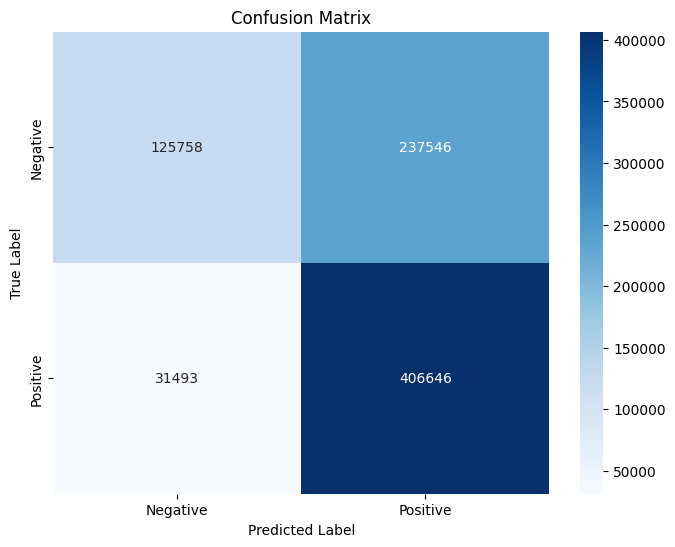

{'Accuracy': 0.6643067566876247,
 'Precision': 0.6312496895335552,
 'Recall': 0.928120984436446,
 'F1 Score': 0.75142631967485,
 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.80      0.35      0.48    363304\n           1       0.63      0.93      0.75    438139\n\n    accuracy                           0.66    801443\n   macro avg       0.72      0.64      0.62    801443\nweighted avg       0.71      0.66      0.63    801443\n',
 'Confusion Matrix': array([[125758, 237546],
        [ 31493, 406646]])}

In [37]:
test_labels= df_critiques['Polarité_réelle']
predictions = df_critiques['Text_blob_critique_nettoyé']

print_metrics(test_labels, predictions)


In [ ]:

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.5, 0.6, 0.7, 0.8, 0.9]}
grid_search = GridSearchCV(model_lr, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search.fit(cv_train_features, polarite_train)

# Print best parameters
print("Best Parameters: ", grid_search.best_params_)

best_model = grid_search.best_estimator_

Cross-validation Scores: [0.8239375 0.8293125 0.826875  0.8241875 0.8213125]
Mean CV Accuracy: 0.8251250000000001

Accuracy: 0.8261
Precision: 0.8278870982103107
Recall: 0.8575117587383565
F1 Score: 0.8424390685874784

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      9157
           1       0.83      0.86      0.84     10843

    accuracy                           0.83     20000
   macro avg       0.83      0.82      0.82     20000
weighted avg       0.83      0.83      0.83     20000



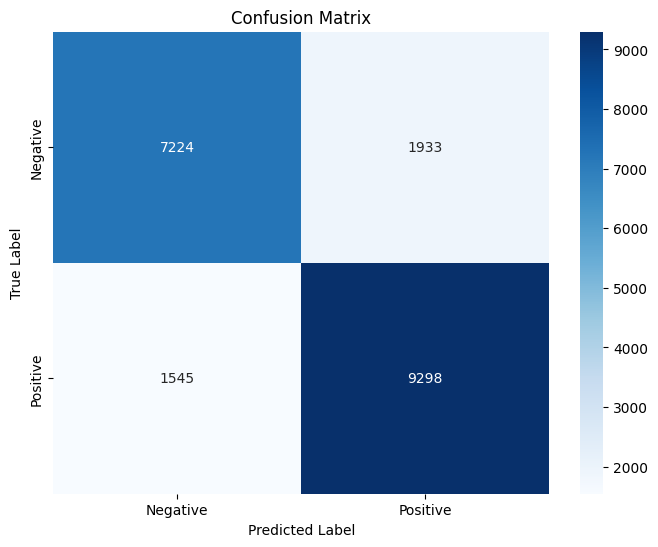

CPU times: user 37min 11s, sys: 3h 17min 2s, total: 3h 54min 14s
Wall time: 5min 54s


In [51]:
%%time
model_lr = LogisticRegression(C=0.5, max_iter=100000)
logistic_regression_results = evaluate_model_final(model_lr, cv_train_features, polarite_train, cv_test_features, polarite_test)

Cross-validation Scores: [0.8115625 0.8189375 0.812     0.8164375 0.811125 ]
Mean CV Accuracy: 0.8140124999999999

Accuracy: 0.8119
Precision: 0.8141804951637235
Recall: 0.84616803467675
F1 Score: 0.8298661360347322

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      9157
           1       0.81      0.85      0.83     10843

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



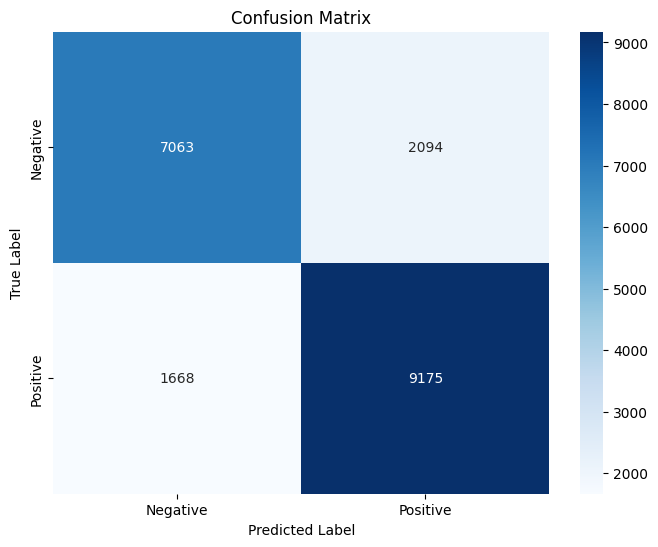

CPU times: user 49min 20s, sys: 3.24 s, total: 49min 23s
Wall time: 49min 23s


In [55]:
%%time
# Example with Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_results = evaluate_model_final(random_forest, cv_train_features, polarite_train, cv_test_features, polarite_test)

Cross-validation Scores: [0.80175   0.80875   0.8026875 0.800125  0.7998125]
Mean CV Accuracy: 0.8026250000000001

Accuracy: 0.80535
Precision: 0.8128939312083558
Recall: 0.832610901042147
F1 Score: 0.8226342885780673

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      9157
           1       0.81      0.83      0.82     10843

    accuracy                           0.81     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.81      0.81      0.81     20000



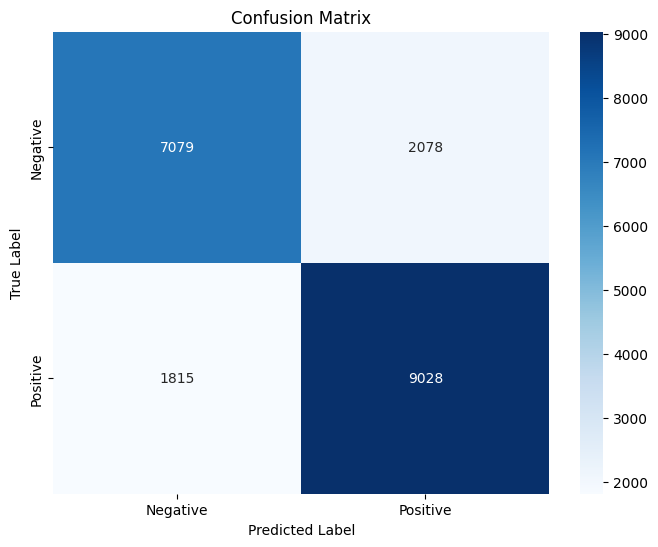

CPU times: user 10h 20min 39s, sys: 0 ns, total: 10h 20min 39s
Wall time: 15min 38s


In [52]:
%%time
# Example with Support Vector Machine
svm = SVC(kernel='linear', C=1)
svm_results = evaluate_model_final(svm, cv_train_features, polarite_train, cv_test_features, polarite_test)

Cross-validation Scores: [0.8200625 0.8259375 0.82475   0.8285    0.8170625]
Mean CV Accuracy: 0.8232624999999999

Accuracy: 0.8235
Precision: 0.8273793535679111
Recall: 0.8522549110024901
F1 Score: 0.839632927494094

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      9157
           1       0.83      0.85      0.84     10843

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000



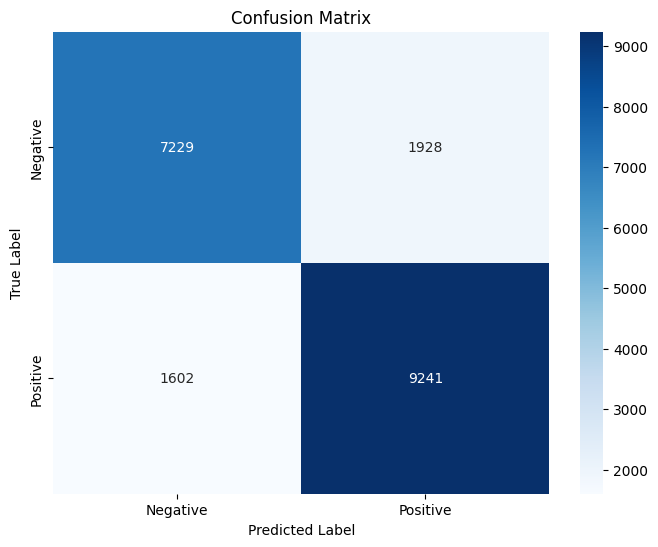

CPU times: user 478 ms, sys: 200 ms, total: 678 ms
Wall time: 432 ms


In [56]:
%%time
# Naive Bayes on Count Vectors

model_MultinomialNB= naive_bayes.MultinomialNB()
MultinomialNB_results = evaluate_model_final(model_MultinomialNB, cv_train_features, polarite_train, cv_test_features, polarite_test)

## CamemBERT    

In [68]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, AdamW, get_linear_schedule_with_warmup

In [58]:
df_critiques_mod

,id_allocine,Critique,Note_critique_float,new_date,Polarité_réelle,Critique_nettoy,nb_mots,Text_blob_critique_nettoyé
207679,265088,Un film qui accumule tous les clichés du genre...,1.0,2021-12-05,0,film accumule tous clichés genre prévisible mo...,36,0
713956,182749,Je le trouve que c'est plus une comédie qu'une...,2.5,2012-11-24,0,trouve plus comédie tragédie bon passe bon mom...,47,1
541942,181541,"Du grand Art. Des personnages , une histoire ,...",4.5,2011-08-11,1,grand art personnages histoire question tous i...,25,1
647337,131737,Un très bon film base sur une pièce de théâtre...,4.0,2011-12-01,1,très bon film base pièce théâtre efficace bien...,43,1
790962,197655,Quentin Dupieux revient avec une comédie à sa ...,3.0,2014-05-07,0,quentin dupieux revient comédie sauce permet e...,55,1
...,...,...,...,...,...,...,...,...
512662,206892,"Un Bond en dent de scie, Spectre reste dans l'...",2.5,2015-11-12,0,bond dent scie spectre reste skyfall gros poin...,41,1
548653,251315,"Pfiou, ce film m'a fait fumer le cerveau. Si j...",3.5,2020-12-07,1,pfiou film a fait fumer cerveau si pense avoir...,423,1
793420,195128,je trouve toujours excellent les X-Men il faut...,4.5,2014-06-23,1,trouve toujours excellent faut toujours aller ...,31,1
85122,228473,Ce film est génial! Spielberg a fait très fort...,4.5,2016-01-22,1,film génial spielberg a fait très fort film ar...,138,1


In [60]:
df_critiques_mod__ = df_critiques_mod[df_critiques_mod['nb_mots'] <= 340]

In [61]:
df_critiques_mod__

,id_allocine,Critique,Note_critique_float,new_date,Polarité_réelle,Critique_nettoy,nb_mots,Text_blob_critique_nettoyé
207679,265088,Un film qui accumule tous les clichés du genre...,1.0,2021-12-05,0,film accumule tous clichés genre prévisible mo...,36,0
713956,182749,Je le trouve que c'est plus une comédie qu'une...,2.5,2012-11-24,0,trouve plus comédie tragédie bon passe bon mom...,47,1
541942,181541,"Du grand Art. Des personnages , une histoire ,...",4.5,2011-08-11,1,grand art personnages histoire question tous i...,25,1
647337,131737,Un très bon film base sur une pièce de théâtre...,4.0,2011-12-01,1,très bon film base pièce théâtre efficace bien...,43,1
790962,197655,Quentin Dupieux revient avec une comédie à sa ...,3.0,2014-05-07,0,quentin dupieux revient comédie sauce permet e...,55,1
...,...,...,...,...,...,...,...,...
315501,172227,Le film démarre lentement et reste lent tout l...,4.0,2021-05-21,1,film démarre lentement reste lent tout temp dé...,46,1
512662,206892,"Un Bond en dent de scie, Spectre reste dans l'...",2.5,2015-11-12,0,bond dent scie spectre reste skyfall gros poin...,41,1
793420,195128,je trouve toujours excellent les X-Men il faut...,4.5,2014-06-23,1,trouve toujours excellent faut toujours aller ...,31,1
85122,228473,Ce film est génial! Spielberg a fait très fort...,4.5,2016-01-22,1,film génial spielberg a fait très fort film ar...,138,1


In [62]:
critique = df_critiques_mod__['Critique'].values.tolist()
polarite = df_critiques_mod__['Polarité_réelle'].values.tolist()

print(len(critique))
print(len(polarite))


95069
95069


In [69]:
# Séparer les données en ensembles d'entraînement et de test
split_border = int(len(polarite)*0.8)
critique_train, critique_test = critique[:split_border], critique[split_border:]
polarite_train, polarite_test = polarite[:split_border], polarite[split_border:]

# Charger le modèle Camembert pré-entraîné et le tokenizer
model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)
model = CamembertForSequenceClassification.from_pretrained(model_name)

print(len(critique_train))
print(len(polarite_train))

print(len(critique_test))
print(len(polarite_test))


ImportError: 
CamembertTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [66]:
pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.0 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [74]:
import torch
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# Prétraiter les données
def preprocess_data(critique, polarite, tokenizer):
    encoded = tokenizer.batch_encode_plus(
        critique,
        add_special_tokens=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt')

    polarite_ = torch.tensor(polarite)

    return encoded['input_ids'], encoded['attention_mask'], polarite_
    #torch.tensor(polarite_onehot, dtype=torch.float32)


In [106]:
input_ids, attention_mask, polarite = preprocess_data(critique_train, polarite_train, tokenizer)
print(input_ids.shape)
print(attention_mask.shape)
print(polarite.shape)
train_dataset = TensorDataset(input_ids, attention_mask, polarite)


input_ids, attention_mask, polarite = preprocess_data(critique_test, polarite_test, tokenizer)
print(input_ids.shape)
print(attention_mask.shape)
print(polarite.shape)
test_dataset = TensorDataset(input_ids, attention_mask, polarite)


/home/onyxia/work/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


torch.Size([7596, 503])
torch.Size([7596, 503])
torch.Size([7596])
torch.Size([1899, 493])
torch.Size([1899, 493])
torch.Size([1899])


In [107]:
# Déplacez le modèle sur le GPU s'il est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Déplacez les données d'entraînement sur le GPU
input_ids_train, attention_mask_train, polarite_train = input_ids.to(device), attention_mask.to(device), polarite.to(device)
train_dataset = TensorDataset(input_ids_train, attention_mask_train, polarite_train)

# Déplacez les données de test sur le GPU
input_ids_test, attention_mask_test, polarite_test = input_ids.to(device), attention_mask.to(device), polarite.to(device)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, polarite_test)


# Define data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Define training parameters
epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


In [108]:
# Train the model
model.train()
for epoch in range(epochs):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels.unsqueeze(1))
        loss = outputs.loss
        loss.backward()
        optimizer.step()

In [109]:
# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).tolist())
        true_labels.extend(labels.squeeze().tolist())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


# 2) Visualisation des données

Cette étape est importante car elle nous permet d'avoir une première vision de données et de voir les premières relations entre nos variables d'intérêt.

### a) Statistiques descriptives

In [28]:
columns_to_include = ['Notes spectateur', 'Nombre_de_critiques_presse','Nombre_de_notes_spectateurs', 'Nombre_de_critiques_spectateurs', 'budget', 'popularity',
                       'revenue', 'vote_average', 'vote_count','duree_du_film', 'collection' ]

# Afficher des statistiques descriptives
summary_stats = df_modified[columns_to_include].describe()

# Afficher le tableau des statistiques
table = tabulate(summary_stats, headers='keys', tablefmt='fancy_grid', numalign="center", stralign="center")

# Afficher le tableau
print(table)


╒═══════╤════════════════════╤══════════════════════════════╤═══════════════════════════════╤═══════════════════════════════════╤═════════════╤══════════════╤═════════════╤════════════════╤══════════════╤═════════════════╤══════════════╕
│       │  Notes spectateur  │  Nombre_de_critiques_presse  │  Nombre_de_notes_spectateurs  │  Nombre_de_critiques_spectateurs  │   budget    │  popularity  │   revenue   │  vote_average  │  vote_count  │  duree_du_film  │  collection  │
╞═══════╪════════════════════╪══════════════════════════════╪═══════════════════════════════╪═══════════════════════════════════╪═════════════╪══════════════╪═════════════╪════════════════╪══════════════╪═════════════════╪══════════════╡
│ count │        3530        │             1478             │             3530              │               3530                │    3530     │     3530     │    3530     │      3530      │     3530     │      3530       │     3530     │
├───────┼────────────────────┼──────────────────

### b) Répartition au niveau des genres

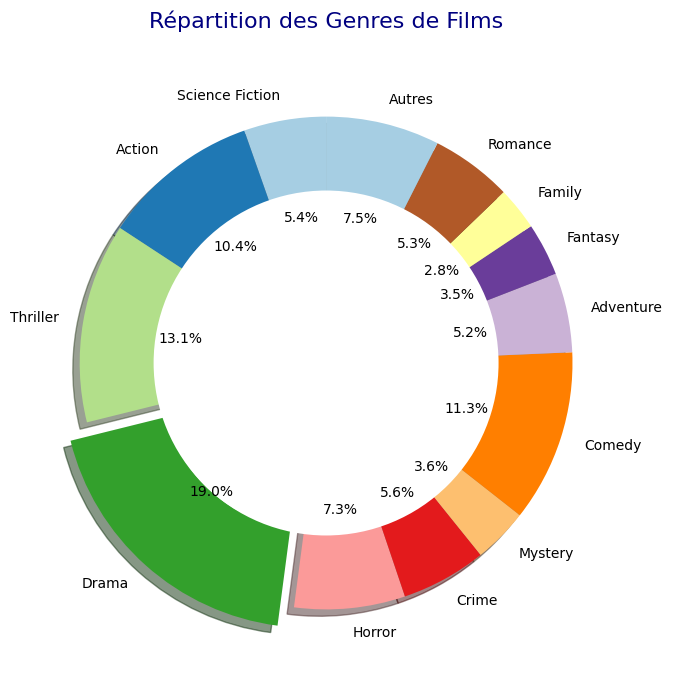

In [29]:
genres_columns = ['Science Fiction', 'Action', 'Thriller', 'Drama', 'Horror',
                   'Crime', 'Mystery', 'Comedy', 'Adventure', 'History', 'War',
                   'Fantasy', 'Family', 'Romance', 'TV Movie', 'Western',
                   'Music', 'Animation', 'Documentary']

# Somme des genres par colonne
genres_counts = df_modified[genres_columns].sum()

# Trouve le genre avec la plus grande part
max_genre = genres_counts.idxmax()

# Regrouper les genres moins fréquents sous "Autres" si nécessaire
seuil = 0.1  # Ajustez cette valeur en fonction de votre préférence
genres_counts['Autres'] = genres_counts[genres_counts < seuil * genres_counts.max()].sum()
genres_counts = genres_counts[genres_counts >= seuil * genres_counts.max()]

# Ajoute une entrée pour le genre principal (avec effet de relief)
explode = [0.1 if genre == max_genre else 0 for genre in genres_counts.index]


plt.figure(figsize=(8, 8))
plt.pie(genres_counts, labels=genres_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors, explode=explode,wedgeprops=dict(width=0.4),
        shadow=True)

plt.gca().add_artist(plt.Circle((0, 0), 0.70, fc='white'))

# Titre et personnalisation
plt.title('Répartition des Genres de Films', pad=20, fontsize=16, color='navy')

plt.show()

On observe que notre base est assez bien équilibré. Même si le genre Drama est en tête, on voit que les autres genres ont à peur près la même part. Cela est intéréssant car ça nous permet de ne pas avoir de biais de sélection au niveau du genre dans notre étude.

### c) Répartition au niveau des pays de production

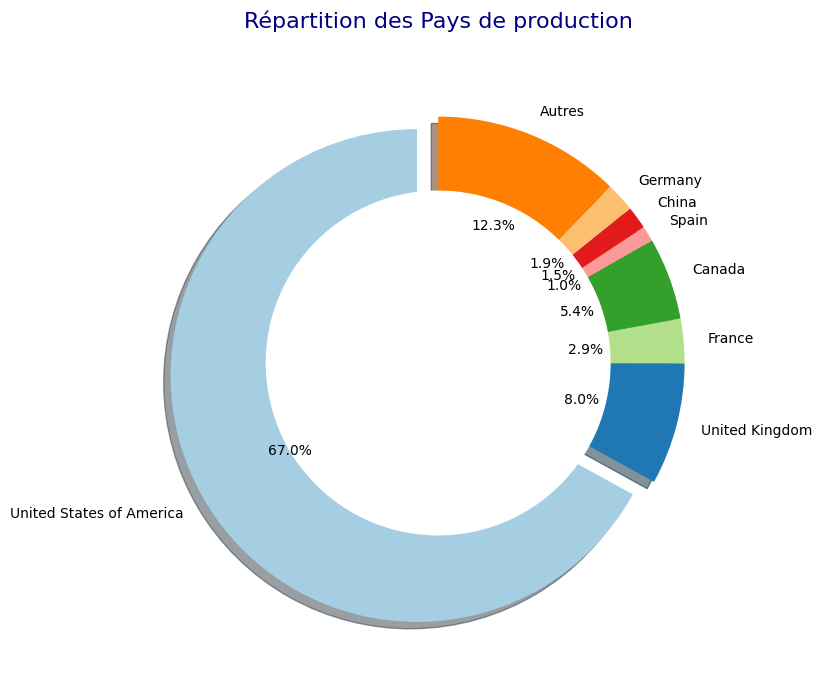

In [30]:
all_countries= ['United States of America','United Kingdom', 'France', 'Malta', 'Morocco', 'Canada', 'India', 'Spain', 'Australia', 'Iceland', 'Norway',
             'South Africa','China','Chile','Dominican Republic','Hungary','Japan','Mexico','Italy','Bulgaria','Germany','Brazil','Hong Kong','Indonesia',
             'Romania','Switzerland','United Arab Emirates','Argentina','Belgium','Greece','Israel','Sweden','New Zealand', 'Portugal', 'Denmark', 'Singapore',
             'Ghana','Bahamas','Nigeria','Bolivia','Netherlands','Ireland', 'Peru', 'Austria', 'Czech Republic', 'Costa Rica', 'Serbia', 'Malaysia', 'South Korea',
             'Luxembourg','Taiwan','Poland','Thailand','Puerto Rico','Kenya','Philippines','Cambodia', 'Colombia', 'Cuba', 'Panama', 'Russia', 'Finland',
             'Cyprus', 'Ukraine', 'Lebanon', 'Lithuania', 'Qatar', 'Jordan', 'Uruguay', 'Senegal', 'Iraq', 'Albania', 'Malawi', 'Turkey', 'Iran']

# Somme des genres par colonne
countries_counts = df_modified[all_countries].sum()

max_countries = countries_counts.idxmax()

# Regrouper les genres moins fréquents sous "Autres" si nécessaire
seuil = 0.015 
countries_counts['Autres'] = countries_counts[countries_counts < seuil * countries_counts.max()].sum()
countries_counts = countries_counts[countries_counts >= seuil * countries_counts.max()]

explode = [0.1 if genre == max_countries else 0 for genre in countries_counts.index]

plt.figure(figsize=(8, 8))
plt.pie(countries_counts, labels=countries_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors, explode=explode,wedgeprops=dict(width=0.4),
        shadow=True)

plt.gca().add_artist(plt.Circle((0, 0), 0.70, fc='white'))

plt.title('Répartition des Pays de production', pad=20, fontsize=16, color='navy')

plt.show()

### d) Critiques

#### i) effet temporel 

In [1]:
# Extraire l'année à partir de la colonne 'new_date'
df_critiques['Année'] = df_critiques['new_date'].dt.year

# Grouper par année et compter le nombre de critiques
evolution_critiques = df_critiques.groupby('Année').size()

# Créer un graphique linéaire
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Premier graphique (évolution du nombre de critiques par année)
axes[0].plot(evolution_critiques.index, evolution_critiques.values, marker='o', linestyle='-')
axes[0].set_title('Évolution du nombre de critiques par année')
axes[0].set_xlabel('Année')
axes[0].set_ylabel('Nombre de critiques')
axes[0].grid(True)

# Deuxième graphique (histogramme de l'année de sortie des films)
axes[1].hist(df_modified['annee_sortie'], bins=range(df_modified['annee_sortie'].min(), df_modified['annee_sortie'].max() + 1), edgecolor='black')
axes[1].grid(linestyle="dashed", alpha=0.5, color="black")
axes[1].set_xlabel('Année de sortie')
axes[1].set_ylabel('Effectif')
axes[1].set_title('Histogramme de l\'effectif des films en fonction de l\'année de sortie des films')

# Ajuster l'espacement entre les deux graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()


NameError: name 'df_critiques' is not defined

#### ii) Effet genres

#### iii) WORDCLOUD

In [7]:
df_critiques_modif=pd.read_csv("df_critiques_modif.csv")

In [8]:
df_critiques_modif.head()

,id_allocine,Critique,Note_critique_float,new_date,Polarité_réelle,nb_mots,Critique_nettoye,Text_blob_critique_nettoyé
0,239331,"""10.000 days"" est à la base une série créée pa...",0.5,2015-10-05,0,129,day base série créée eric small réalise film o...,0
1,239331,Les effets spéciaux bas de gamme mettent les a...,1.0,2015-12-12,0,18,effets spéciaux ba gamme mettent acteurs situa...,0
2,239331,"10,000 somnifères. A peine ça commence qu'un g...",1.0,2017-01-10,0,45,somnifères a peine ça commence gar raconte lif...,0
3,239331,"""10 000 days"" est d'une nullité abyssale. Tout...",0.5,2016-05-24,0,84,10 000 day nullité abyssale tout concourt fair...,0
4,239331,"Beaucoup de parlotes, pas d'action ni d'effets...",1.5,2017-01-01,0,22,beaucoup parlotes ni spéciaux histoire molle t...,0


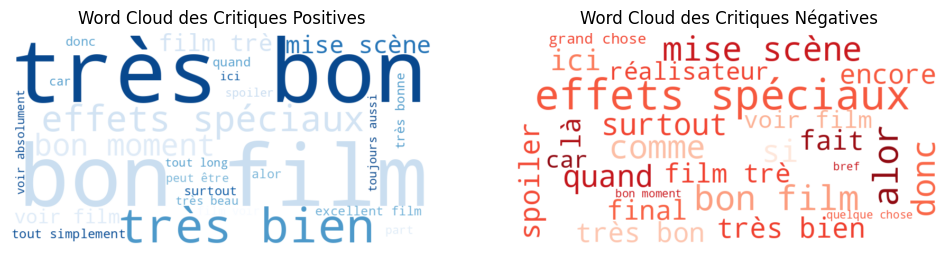

In [14]:

# Filtrer les critiques positives et négatives
positive_reviews = df_critiques_modif[df_critiques_modif['Polarité_réelle'] == 1]['Critique_nettoye'].values
negative_reviews = df_critiques_modif[df_critiques_modif['Polarité_réelle'] == 0]['Critique_nettoye'].values

# Création du Word Cloud pour les critiques positives
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', max_words=25, colormap='Blues').generate(' '.join(positive_reviews))

# Création du Word Cloud pour les critiques négatives
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', max_words=25, colormap='Reds').generate(' '.join(negative_reviews))

# Affichage des Word Clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud des Critiques Positives')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud des Critiques Négatives')
plt.axis('off')

plt.show()


On voit qu'en visualisant sur l'ensemble de la base de données il est difficile de voir une distinction nette. Néanmoins, on peut quand même voir quelques mots qui ressortent comme : 

#### e) Analyse au niveau individuel par film 

In [28]:
# Wordcloud positive/négative au niveau de chaque film 
id_unique = df_critiques_modif["id_allocine"].unique().tolist()
len(id_unique)

3526

In [22]:
df_modified=pd.read_csv("df_modified.csv")

Dans un premier temps, on essaie de regarder les mots qui reviennent dans les critiques positives(et négatives) de chaque film. En effet, à chaque exécution, le code ci-dessous, renvoie les wordcloud associés aux films choisis aléatoirement.

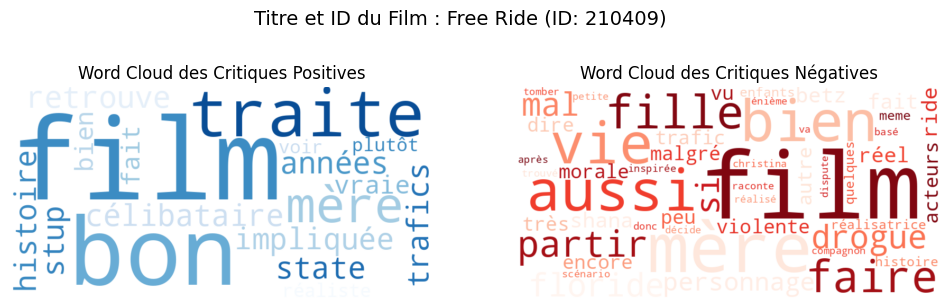

In [43]:
# Sélection aléatoire d'un identifiant avec au moins une critique positive et une critique négative
id_aleatoire = None
while id_aleatoire is None or len(df_critiques_modif[(df_critiques_modif['id_allocine'] == id_aleatoire) & (df_critiques_modif['Polarité_réelle'] == 1)]) == 0 or len(df_critiques_modif[(df_critiques_modif['id_allocine'] == id_aleatoire) & (df_critiques_modif['Polarité_réelle'] == 0)]) == 0:
    id_aleatoire = random.choice(id_unique)


# Filtrer les critiques pour l'identifiant sélectionné
critiques_positives = df_critiques_modif[(df_critiques_modif['id_allocine'] == id_aleatoire) & (df_critiques_modif['Polarité_réelle'] == 1)]['Critique_nettoye'].values
critiques_negatives = df_critiques_modif[(df_critiques_modif['id_allocine'] == id_aleatoire) & (df_critiques_modif['Polarité_réelle'] == 0)]['Critique_nettoye'].values

# Création du Word Cloud pour les critiques positives
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', max_words=50, colormap='Blues').generate(' '.join(critiques_positives))

# Création du Word Cloud pour les critiques négatives
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', max_words=50, colormap='Reds').generate(' '.join(critiques_negatives))

# Affichage des Word Clouds
plt.figure(figsize=(12, 6))

# Affichage du Word Cloud pour les critiques positives
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud des Critiques Positives')
plt.axis('off')

# Affichage du Word Cloud pour les critiques négatives
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud des Critiques Négatives')
plt.axis('off')

# Titre général en dessous des deux graphiques
plt.suptitle(f'Titre et ID du Film : {df_modified[df_modified["id allocine"] == id_aleatoire]["Titre original"].values[0]} (ID: {id_aleatoire})', y=0.8, size=14)

plt.show()



# 3) Modélisation 

# Conclusion 